In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy as np

/home/ollie/pscholz/tripyview_github


In [2]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None 
save_fname= None

#_____________________________________________________________________________________
which_cycl= 5
which_mode= 'hovm'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'temp'
year      = [1958, 2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
box_region = list()
box_region.append('global')
# box_region.append('ocean_basins/Arctic_Basin.shp')
# box_region.append('ocean_basins/Eurasian_Basin.shp')
# box_region.append('mpas_region/Canada_Basin.shp')
# box_region.append('mpas_region/North_Atlantic_Ocean.shp')
# box_region.append('mpas_region/Greenland_Sea.shp')
# box_region.append('mpas_region/Irminger_Sea.shp')
# box_region.append('mpas_region/Norwegian_Sea.shp')
# box_region.append('mpas_region/Labrador_Sea.shp')
# box_region.append('mpas_region/North_Pacific_Ocean.shp')
# box_region.append('mpas_region/South_Pacific_Ocean.shp')
# box_region.append('mpas_region/Southern_Ocean.shp')
# box_region.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = None
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 3 
which_dpi = 300
do_rescale= None

In [3]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if which_cycl is not None: 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if ref_path is not None:
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
        
#______________________________________________________________________________________________________        
cinfo=dict({'cstr':cstr, 'cnum':cnum}) 
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac  
if climit   is not None: cinfo['climit']=climit  
if chist    is not None: cinfo['chist' ]=chist
if ctresh   is not None: cinfo['ctresh']=ctresh    
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record

#______________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region is 'global' or isinstance(region,list): box.append(region)
    else: 
        print(tpv.__path__[0],region)
        box.append(shp.Reader(os.path.join(shp_path,region)))    

 > found *.pckl file: /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/


In [4]:
#___LOAD FESOM2 REFERENCE DATA________________________________________________________________________
if ref_path is not None:
    print(ref_path)
    if not vname=='Kv*N2':
        data_ref = tpv.load_data_fesom2(mesh, ref_path, vname=vname, year=ref_year, mon=ref_mon, 
                                        descript=ref_name, do_tarithm='None', do_zarithm='None', do_info=False) 
    else:
        data_ref  = tpv.load_data_fesom2(mesh, ref_path, vname='Kv', year=ref_year, mon=ref_mon, 
                                        descript=ref_name, do_tarithm='None', do_zarithm='None', do_info=False) 
        data2_ref = tpv.load_data_fesom2(mesh, ref_path, vname='N2', year=ref_year, mon=ref_mon, 
                                        descript=ref_name, do_tarithm='None', do_zarithm='None', do_info=False) 
        data_ref['Kv'].data = data_ref['Kv'].data * data2_ref['N2'].data
        data_ref  = data.rename(dict({'Kv':'Kv*N2'}))
        data_ref['Kv*N2'].attrs['units'], data_ref['Kv*N2'].attrs['description'], data_ref['Kv*N2'].attrs['long_name'] = 'm^2/s^3', 'Kv * N^2', 'Kv * N^2'
        del(data2_ref)
        
    data_ref = tpv.load_index_fesom2(mesh, data_ref, box, do_harithm='wmean')

#___LOAD FESOM2 DATA___________________________________________________________________________________
list_hovm  = list()
for datapath, descript in zip(input_paths, input_names):
    print(datapath)
    if not vname=='Kv*N2':
        data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, 
                                     descript=descript, do_tarithm='None', do_zarithm='None', do_info=False)
    else:
        data  = tpv.load_data_fesom2(mesh, datapath, vname='Kv', year=year, mon=mon, 
                                     descript=descript, do_tarithm='None', do_zarithm='None', do_info=False)
        data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2', year=year, mon=mon, 
                                     descript=descript, do_tarithm='None', do_zarithm='None', do_info=False)
        data['Kv'].data = data['Kv'].data * data2['N2'].data
        data  = data.rename(dict({'Kv':'Kv*N2'}))
        data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] = 'm^2/s^3', 'Kv * N^2', 'Kv * N^2'
        del(data2)
    
    data_hovm = tpv.load_index_fesom2(mesh, data, box, do_harithm='wmean')
    
    #_________________________________________________________________________________________________
    if ref_path is not None: 
        list_hovm.append(tpv.do_indexanomaly(data_hovm, data_ref))
    else: 
        list_hovm.append(data_hovm)
    del(data, data_hovm)
    
if ref_path is not None: del(data_ref)    

/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/


--> histo: cmin, cmax =  -0.009200879866103734 18.17173773555487
{'cstr': 'blue2red', 'cnum': 20, 'chist': True, 'ctresh': 0.995, 'cmin': -0.0092, 'cmax': 18.1717, 'cref': 9.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f7db0285450>, 'clevel': array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,
        5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ,
       10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5,
       16. , 16.5, 17. , 17.5, 18. , 18.5])}


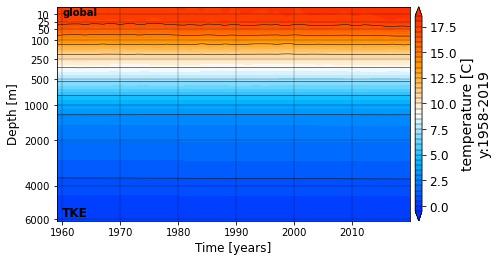

In [5]:
#___PLOT HOVM__________________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = list_hovm[0][0][sname].attrs['str_lsave']
sbox   = list_hovm[0][0][vname].attrs['boxname'].replace(' ','_').lower()
if spath is not None: spath  = '{}/{}_{}_{}_{}.png'.format(spath, which_mode, sname, sbox, slabel) 
ncolumn= np.min([ncolumn,len(list_hovm)])    
nrow   = np.ceil(len(list_hovm)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
fig, ax, cbar = tpv.plot_index_hovm(list_hovm, box, cinfo=cinfo, figsize=[ncolumn*7, nrow*3.5], n_rc=[nrow, ncolumn], 
                                pos_gap=[0.01, 0.01], pos_extend=[0.05, 0.05, 0.85,0.90], do_rescale=do_rescale, 
                                do_save = spath, save_dpi=which_dpi )